<a href="https://colab.research.google.com/github/cing3000/Reinforcement-Learning-An-Introduction/blob/master/Reinforcement_Learning_Notebook_Chapter_5_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5 Monte Carlo Methods

Unlike DP, we do not assume complete knowledge of the envionment. Monte Carlo methods require only **experience** --- sample sequences of states, actions, and rewards from actual or simulated interaction with an environment.

Monte Carlo methods are ways of solving the reinforcement learning problem based on averaging sample returns.

We assume experience is divided into episodes, and that all episodes eventually terminate no matter what actions are selected. Only on the completion of an episode are value estimates and policies changed.

## 5.1 Monte Carlo Prediction

The **first-visit MC method** estimates $v_\pi(s)$ as the average of the returns folloing first visits to $s$.

The **every-visit MC method** averages the returns following all visits to $s$.


First-visit MC prediction, for estimating $V\approx v_\pi$:

---
Initialize:
>$\pi \leftarrow $ policy to be evaluated<br/>
>$V \leftarrow $ an arbitrary state-value function<br/>
>$Returns(s)\leftarrow $ an empty list, for all $s \in \mathcal{S}$

Repeat forever:
>Generate an episode using $\pi$<br/>
>For each state $s$ apperaring in the episode:
>>$G \leftarrow $ the return that follows the first occurrence of $s$<br/>
>>Append $G$ to $Returns(s)$<br/>
>>$V(s) \leftarrow average(Returns(s))$
---

DP methods require the distribution of next events - in particular, they require the environments dynamics as given by the four-argument function $p$ - and it is not easy to dertermine this for many cases.

Advantages in Monte Carlo methods:
* <font color='red'>For Monte Carlo estmation of $v_\pi$, the root is a state node, and below it is the entire trajectory of transitions along a particular single episode, ending at the terminal state.</font>
* <font color='red'>The estimates for each state are independent. In other words, Monte Carlo methods do not _bootstrap_ as we defined it in DP.</font>
* <font color='red'>The computational expense of estimating the value of a single state is independent of the number of states. This can make Monte Carlo methods particularly attractive when one requires the value of only one or a subset of states.</font>



**Example 5.1: Blackjack**

The object of the popular casino card game of blackjack is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21.

All face cards count as 10, and an ace can count either as 1 or as 11.

We consider the version in which each player competes independently against the dealer.

The game begins with two cards dealt to both dealer and player. One of the dealer's cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. 

If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust).

If he goes bust, he loses; if he sticks, then it becomes the dealer's turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome - win, lose, or draw - is determined by whose final sum is closer to 21.

Step 0 in 7.31 secs, state-value diff: -9.0135
Step 10 in 8.75 secs, state-value diff: 0.1583
Step 20 in 8.80 secs, state-value diff: 0.0174
Step 30 in 8.70 secs, state-value diff: 0.0044
Step 40 in 8.76 secs, state-value diff: 0.0109


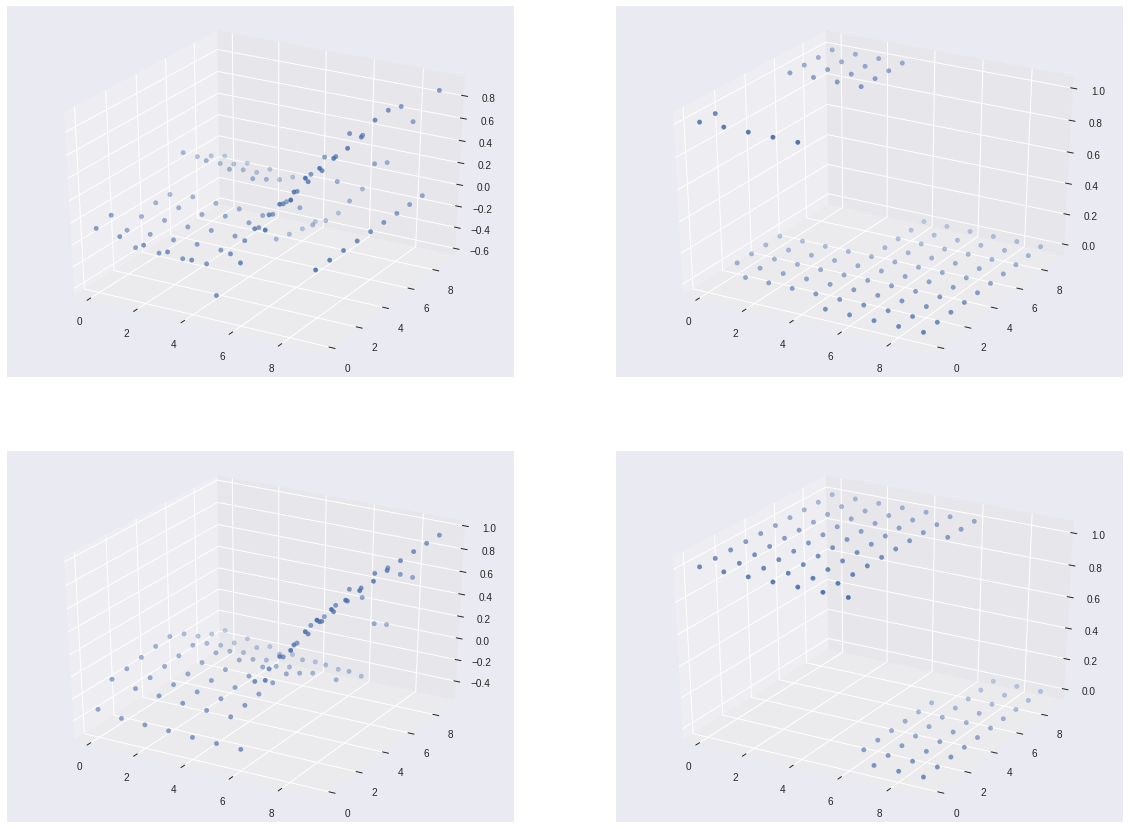

In [0]:
import numpy as np
import time

# States space size:
#   player's current sum 12~21 (0~9), the dealer's one showing card ace~10 (0x~9x),
#   and whether or not player holds a usable ace (0xx ~ 1xx).
S = 200

# Action space size: hit (1) or stick (0)
A = 2

# Initialize policy
pi = np.zeros(S)

# Initialize state-value function
V = np.zeros(S)

# An empty list for returns (separated into sum and number)
RETS_SUM = np.zeros(S)
RETS_CNT = np.zeros(S)

# Total episodes
EP = 500000

# state decoder
def decode(s):
    return s%10+12, s>99, s//10%10+1

def encode(p, a, d):
    x = p-12 + (d-1)*10
    return x if a else (100+x)

def cal_points(cards):
    pts = 0
    useful_ace = False
    for c in cards:
        pts += (10 if c>=10 else c)
    if 1 in cards and pts+10<21:
        pts += 10
        useful_ace = True
    return pts, useful_ace

# episode generator
def play():
    
    # Initial state
    player_cards = [np.random.randint(1, 14), np.random.randint(1, 14)]
    dealer_cards = [np.random.randint(1, 14)]
    
    player, ace = cal_points(player_cards)
    dealer = dealer_cards[0] if dealer_cards[0]<10 else 10

    state = encode(player, ace, dealer)
    states_stack = []
    
    #print("Player has %d %s a usable ace, dealer's showing card is %d, " % (decode(state)))
    
    # Start play
    termination = False
    r = -1
    player_final = 0
    
    while not termination:
        
        # push current state to stack
        states_stack.append(state)
        
        # decode state, player's hand, with/without usable ace, and dealer's showing card
        player, ace, dealer = decode(state)
        
        if pi[state] == 1:
            # hit
            player_cards.append(np.random.randint(1, 14))
            new_pts, new_ace = cal_points(player_cards)
            
            if new_pts > 21:
                termination = True
                r = -1
            else:
                player = new_pts
                ace = new_ace
                
                # update to new state
                state = encode(player, ace, dealer)

            player_final = new_pts
        else:
            termination = True
            player_final = player

    # dealer's turn
    dealer_cards.append(np.random.randint(1, 14))
    dealer, _ = cal_points(dealer_cards)

    while dealer < 17:
        # hit
        dealer_cards.append(np.random.randint(1, 14))
        dealer, _ = cal_points(dealer_cards)

    if player_final <= 21 and (player_final > dealer or dealer > 21):
        r = 1
    elif (player_final > 21 and dealer > 21) or player_final == dealer:
        r = 0
    else:
        r = -1
        
    return states_stack, r


for x in range(50):
    
    # tic
    t = time.time()
    old_v_sum = np.sum(V)
    
    # Estimating V
    for i in range(EP):

        # generate a episode using pi
        ss, r = play()

        for s in ss:
            RETS_SUM[s] += r
            RETS_CNT[s] += 1
            V[s] = RETS_SUM[s]/RETS_CNT[s]

    # Update policy
    for s in range(S):
        player, ace, dealer = decode(s)

        # if action is stick, V[s] will be current value, otherwise, 
        # it will be expectation of V[s'], p(s') * V[s'], p(s') is always 1/13
        Ev = 0
        for c in range(1, 14):
            point = c if c < 10 else 10
            new_player = player + point
            if ace and new_player > 21:
                new_player -= 10

            if new_player > 21:
                Ev += -1.0/13
            else:
                Ev += V[new_player]/13.0

        # if hit is better than stick, update policy
        if Ev > V[s]:
            pi[s] = 1
    
    # toc
    if x % 10 == 0:
        print("Step %d in %.2f secs, state-value diff: %.4f" % (x, (time.time()-t), (np.sum(V)-old_v_sum)))


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

fig = plt.figure(figsize=[20, 15])
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(np.tile(np.arange(10), 10), np.repeat(np.arange(10), 10), np.ndarray.flatten(V[0:100]))

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(np.tile(np.arange(10), 10), np.repeat(np.arange(10), 10), np.ndarray.flatten(pi[0:100]))

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(np.tile(np.arange(10), 10), np.repeat(np.arange(10), 10), np.ndarray.flatten(V[100:200]))

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(np.tile(np.arange(10), 10), np.repeat(np.arange(10), 10), np.ndarray.flatten(pi[100:200]))


plt.show()


## 5.2 Monte Carlo Estimation of Action Values

If a model is not available, then it is particularly useful to estimate _action_ values (the values of state-action pares) rather than _state_ values.

The policy evaluation problem for action values is to estimate $q_\pi(s, a)$, the expected return when sstarting in state $s$, taking action $a$, and thereafter following policy $\pi$.

The only complication is that many state-action pairs may never be visted. To compare alternatives we need to estimate the value of **all** the actions from each state, not just the one we currently favor.

This is general problem of **_maintaining exploration_**.
* One way to do this is by specifiying that the episodes _start in a state-action pair_, and that every pair has a nonzero probability of being selected as the start. We call this the assumption of _exploring starts_.
* The most common alternative approach to assuring that all state-action pairs are encountered is to consider only policies that are stochastic with a nonzero probablity of selecting all actions in each state.

## 5.3 Monte Carlo Control

The overall idea of Monte Carlo control is to proceed according to the idea of generalized policy iteration (**GPI**).


<img src="http://www.incompleteideas.net/book/ebook/imgtmp6.png" width="200" />

Monte Carlo version of classical policy iteration:

$$ \pi_0 \overset{E}{\longrightarrow} v_{\pi0} \overset{I}{\longrightarrow} \pi_1 \overset{E}{\longrightarrow} \cdots \overset{I}{\longrightarrow} \pi_* \overset{E}{\longrightarrow} v_* $$

where $\overset{E}{\longrightarrow}$ denotes a complete policy evaluation and $\overset{I}{\longrightarrow}$ denotes a complete policy improvement.

**Monte Carlo ES (Exploring Starts), for estimating $\pi \approx \pi_*$**

---
Initialize, for all $s \in \mathcal{S}, a \in \mathcal{A}(s)$:
>$Q(s,a)\leftarrow$ arbitrary<br/>
>$\pi(s)\leftarrow$ arbitrary<br/>
>$Returns(s,a)\leftarrow$ empty list

Repeat forever:
>Choose $S_0 \in \mathcal{S}$ and $A_0 \in \mathcal{A}(S_0)$ s.t. all pairs have probability $\gt 0$<br/>
>Generate an episode starting from $S_0, A_0$, following $\pi$<br/>
>For each pair $s,a$ appearing in the episode:
>>$G\leftarrow$ the return that follows the first occurrence of $s,a$<br/>
>>Append $G$ to $Returns(s,a)$<br/>
>>$Q(s,a) \leftarrow average(Returns(s,a))$

>For each $s$ in the episode:
>>$\pi(s)\leftarrow argmax_aQ(s,a)$
---

In Monte Carlo ES, Convergence to a optimal fixed point seems inevitable as the changes to the action-value function decrease over time, but has not yet been formally proved.

## 5.4 Monte Carlo Control without Exploring Starts

Two approaches: **on-plicy** methods and **off-policy** methods.

**On-policy** methods attempt to evaluate or improve the policy that is used to make decisions.

**Off-policy** methods evaluate or imporove a policy different from that used to generate the data.

In on-policy control methods the policy is generally _soft_, meaning that $\pi(a\mid s)\gt 0$ for all $s \in \mathcal{S}$ and all $a \in \mathcal{A}(s)$, but gradually shifted closer and closer to a dertministic optimal policy.

Example in this section uses $\epsilon$-greedy policies. Nongreedy actionsare given the minimal probability of selection, $\frac{\epsilon}{\mid\mathcal{A}(s)\mid}$, and $1-\epsilon+\frac{\epsilon}{\mid\mathcal{A}(s)\mid}$ is given to the greedy action.

**On-plicy first-visit MC control (for $\epsilon$-soft policies), estimates $\pi\approx\pi_\star$**

---
Initialize, for all $s\in\mathcal{S}$, $a\in\mathcal{A}(s)$:
>$Q(s,a)\leftarrow$ arbitrary<br/>
>$Returns(s,a)\leftarrow$ empty list<br/>
>$\pi(a\mid s)\leftarrow$ an arbitrary $\epsilon$-soft policy

Repeat forever:
>Generate an episode using $\pi$<br/>
>For each pair $s,a$ appearing in the episode:
>>$G\leftarrow$ the return that follows the first occurrence of $s,a$<br/>
>>Append $G$ to $Returns(s,a)$<br/>
>>$Q(s,a)\leftarrow average(Returns(s,a))$

>For each $s$ in the episode:
>>$A^\star \leftarrow argmax_a Q(s,a)$<br/>
>>For all $a \in \mathcal{A}(s)$:
>>>$\pi(a\mid s)\leftarrow \begin{cases} 
1-\epsilon+\frac{\epsilon}{\mid\mathcal{A}(s)\mid}&\quad \text{if  } a=A^\star \\
\frac{\epsilon}{\mid\mathcal{A}(s)\mid}&\quad\text{if  } a\neq A^\star\end{cases}$
---




## 5.5 Off-policy Prediction via Importance Sampling

<font color='red'>How can they learn about the optimal policy while behaving according to an exploratory policy?</font>

A more straightforward approach is to use two policies, one that is learned about and becomes the optimal policy, and one that is more exploratory and is used to generate behavior. The policy being learned about is called the **target policy**, and the policy used to generate behavior is called the **behavior policy**. The overall process is termed **_off-policy learning_**.

Prediction problem: both target and behavior policies are fixed. That is we wish to estimate $v_\pi$ or $q_\pi$, but all we have are episodes following another policy $b$, where $b\neq\pi$. In this case, both policies are considered fixed and given.

The assumption of **coverage**: $\pi(a\mid s)\gt 0$ implies $b(a\mid s) \gt 0$.

Almost all off-policy methods utilize **importance sampling**, a general technique for estimating expected values under one distribution given samples from another.

Given a starting state $S_t$, the probability of the subsequent state-action trajectory, $A_t, S_{t+1},A_{t+1},\dots,S_T$, occurring under any policy $\pi$ is:

$$ \begin{align} Pr&\{A_t, S_{t+1},A_{t+1},\dots,S_T \mid S_t, A_{t:T-1} \sim \pi\} \\
 &=\pi(A_t\mid S_t)p(S_{t+1}\mid S_t, A_t)\pi(A_{t+1}\mid S_{t+1})\cdots p(S_T\mid S_{T-1},A_{T-1})\\
&=\prod_{k=t}^{T-1}\pi(A_k\mid S_k)p(S_{k+1}\mid S_k,A_k)\end{align}$$

where $p$ is the state-transition probability function defined by (3.4). Thus, the relative probability of the trajectory under the target and behavior policies (the importance-sampling ratio) is:

$$\rho_{t:T-1}\doteq\frac{\prod_{k=t}^{T-1}\pi(A_k\mid S_k)p(S_{k+1}\mid S_k,A_k)}{\prod_{k=t}^{T-1}b(A_k\mid S_k)p(S_{k+1}\mid S_k,A_k)}=\prod_{k=t}^{T-1}\frac{\pi(A_k\mid S_k)}{b(A_k\mid S_k)} \tag{5.3}$$

<font color='blue'>By following policy $b$, the probability of the subsequent state-action is, e.g. , much higher than one by following policy $\pi$, so the rewards (return) means less when following policy $\pi$, because it has lower probability to happen. Any rewards should have a discounted contribution to $v_\pi(s)$, the discount should be $\rho_{t:T-1}$.</font>

**_Ordinary importance sampling_**:
$$V(s)\doteq\frac{\sum_{t\in\mathcal{T}(s)}\rho_{t:T(t)-1}G_t}{\mid\mathcal{T}(s)\mid} \tag{5.4}$$

**_Weighted importance sampling_**:
$$V(s)\doteq\frac{\sum_{t\in\mathcal{T}(s)}\rho_{t:T(t)-1}G_t}{\sum_{t\in\mathcal{T}(s)}\rho_{t:T(t)-1}} \tag{5.5}$$

** Example 5.4: Off-policy Estimation of a Blackjack State Value **

We applied both ordinary and weighted importance-sampling methods to estimate the value of a single blackjack state from off-policy data. Recall that one of the advantages of Monte Carlo methods is that they can be used to evaluate a single state without forming estimates for any other states.

In this example, we evaluated the state in which the dealer is showing a deuce, the sum of the player's cards is 13, and the player has a usable ace (that is, the player holds an ace and a deuce, or equivalently three aces).

The data was generated by starting in this state then choosing to hit or stick at random with equal probability (the behavior policy). The target policy was to stick only on a sum of 20 or 21, as in Example 5.1.

The value of this state under the target policy is approximately -0.27726 (this was determined by separately generating one-hundred million episodes using the target policy and averaging their returns). 

Both off-policy methods closely approximated this value after 1000 off-policy episodes using the random policy. To make sure they did this reliably, we performed 100 independent runs, each starting from estimates of zero and learning for 10,000 episodes.

100%|##########| 100/100 [00:12<00:00,  7.94it/s]


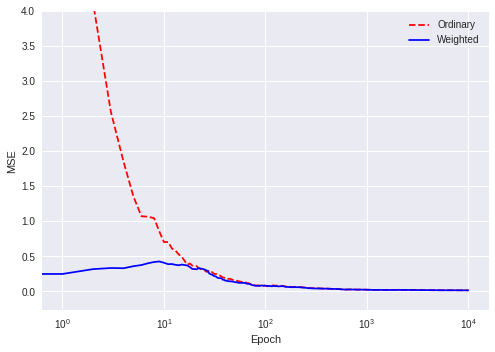

In [0]:
import numpy as np
import time
from tqdm import tqdm

EPISODES = 100000
TARGET = -0.27726

def mse(v):
    return np.square(v-TARGET).mean()

def cal_points(cards):
    pts = 0
    useful_ace = False
    for c in cards:
        pts += (10 if c>=10 else c)
    if 1 in cards and pts+10<21:
        pts += 10
        useful_ace = True
    return pts, useful_ace

# play one episode
def play():
    
    # Initial state
    player_cards = [1, 2]
    dealer_cards = [2]
    
    player, ace = cal_points(player_cards)
    dealer = 2

    # Start play
    termination = False
    r = -1
    player_final = 0
    rho = 1
    
    while not termination:
        
        # Behavior policy
        if np.random.randn()>0:
            
            rho *= (2 if player < 20 else 0)
            
            # hit
            player_cards.append(np.random.randint(1, 14))
            new_pts, new_ace = cal_points(player_cards)

            if new_pts > 21:
                termination = True
                r = -1
            else:
                player = new_pts
                ace = new_ace
                
            player_final = new_pts
        else:
            
            rho *= (2 if player >= 20 else 0)
            
            # stick
            termination = True
            player_final = player

    # dealer's turn
    dealer_cards.append(np.random.randint(1, 14))
    dealer, _ = cal_points(dealer_cards)

    while dealer < 17:
        # hit
        dealer_cards.append(np.random.randint(1, 14))
        dealer, _ = cal_points(dealer_cards)

    if player_final <= 21 and (player_final > dealer or dealer > 21):
        r = 1
    elif (player_final > 21 and dealer > 21) or player_final == dealer:
        r = 0
    else:
        r = -1
        
    return rho, r

# episode generator
def monte_carlo_off_policy(episodes):
    rho_t = []
    G_t = []
    for i in range(episodes):
        rho, r = play()
        rho_t.append(rho)
        G_t.append(r)
    
    rhos = np.array(rho_t)
    Gs = np.array(G_t)
    weighted_returns = rhos * Gs
    weighted_returns = np.add.accumulate(weighted_returns)
    rhos = np.add.accumulate(rhos)

    ordinary_sampling = weighted_returns/np.arange(1, episodes+1)
    with np.errstate(divide='ignore',invalid='ignore'):
        weighted_sampling = np.where(rhos!=0, weighted_returns/rhos, 0)
    
    return ordinary_sampling, weighted_sampling

true_value = -0.27726
episodes = 10000
runs = 100
error_ordinary = np.zeros(episodes)
error_weighted = np.zeros(episodes)
for i in tqdm(range(0, runs), ascii=True):
    ordinary_sampling, weighted_sampling = monte_carlo_off_policy(episodes)
    # get the squared error
    error_ordinary += np.power(ordinary_sampling - true_value, 2)
    error_weighted += np.power(weighted_sampling - true_value, 2)
error_ordinary /= runs
error_weighted /= runs


import matplotlib.pyplot as plt

plt.semilogx(np.arange(episodes), error_ordinary, 'r--')
plt.semilogx(np.arange(episodes), error_weighted, 'b-')
plt.legend(['Ordinary', 'Weighted'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(top=4)
plt.show();

## 5.6 Incremental Implementation

Monte Carlo prediction methods can be implemented incrementally, on an episode-by-episode basis, using extensions of the techniques described in Chapter 2 (Section 2.4).

Suppose we have a sequence of returns $G_1, G_2, \dots, G_{n-1}$, all starting in the same state and each with a corresponding random weight $W_i$ (e.g., $W_i=\rho_{t:T(t)-1}$). We wish to form the estimate
$$ V_n \doteq \frac{\sum_{k=1}^{n-1}W_k G_k}{\sum_{k=1}^{n-1}W_k}, \quad n\geq 2, \tag{5.6}$$

Incremental implementation:
$$ V_{n+1} \doteq V_n + \frac{W_n}{C_n}\Big[G_n-V_n\Big], \quad n\geq 1, \tag{5.7}$$

and
$$ C_{n+1} \doteq C_n+W_{n+1}$$

where $C_0\doteq0$ (and $V_1$ is arbitrary)


** Off-policy MC prediction, for estimating $Q\approx q_\pi$ **

---
Input: an arbitrary target policy $\pi$

Initialize, for all $s \in \mathcal{S}, a \in \mathcal{A}(s)$:
>$Q(s,a)\leftarrow arbitrary$<br/>
>$C(s,a)\leftarrow0$

Repeat forever:
>$b \leftarrow$ any policy with coverage of $\pi$<br/>
>Generate an episode using $b$:
>>$S_0, A_0, R_1,\dots,S_{T-1}, A_{T-1}, R_T, S_T$

>$G\leftarrow 0$<br/>
>$W\leftarrow 1$<br/>
>For $t=T-1, T-2, \dots$ down to $0$:
>>$G\leftarrow\gamma G+R_{t+1}$<br/>
>>$C(S_t, A_t)\leftarrow C(S_t, A_t) + W$<br/>
>>$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{W}{C(S_t, A_t)}\big[G-Q(S_t, A_t)\big]$ <br/>
>>$W\leftarrow W\frac{\pi(A_t|S_t)}{b(A_t|S_t)}$<br/>
>>If $W=0$ then exit For loop

---

## 5.7 Off-policy Monte Carlo Control

** Off-policy MC control, for estimating $\pi\approx\pi_\star$**

---
Initialize, for all $s\in\mathcal{S}, a\in\mathcal{A}(s)$:
>$Q(s,a)\leftarrow$ arbitrary<br/>
>$C(s,a)\leftarrow 0$<br/>
>$\pi(s)\leftarrow argmax_a Q(S_t,a)$

Repeat forever:
>$b\leftarrow$ any soft policy (e.g. $\epsilon$-greedy)<br/>
>Generate an episode using $b$:
>>$S_0, A_0, R1, \dots , S_{T-1}, A_{T-1}, R_T, S_T$

>$G\leftarrow 0$<br/>
>$W\leftarrow 1$<br/>
>For $t=T-1, T-2, \dots$ down to $0$:
>>$G\leftarrow\gamma G+R_{t+1}$<br/>
>>$C(S_t,A_t)\leftarrow C(S_t,A_t)+W$<br/>
>>$Q(S_t,A_t)\leftarrow Q(S_t,A_t)+\frac{W}{C(S_t,A_t)}\big[G-Q(S_t,A_t)\big]$<br/>
>>$\pi(S_t)\leftarrow argmax_a Q(S_t, a)$<br/>
>>If $A_t\neq\pi(S_t)$ then exit For loop<br/>
>>$W\leftarrow W\frac{\pi(A_t|S_t)}{b(A_t|S_t)} = W\frac{1}{b(A_t|S_t)}$

---





** Exercise 5.8: Racetrace **

Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track.

In our simplifed racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by +1, -1, or 0 in one step, for a total of nine actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line.

Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are -1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues.

Before updating the car's location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line.

To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments.

Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).


<img src="http://www.incompleteideas.net/book/ebook/figtmp22.png" width="500"/>

2000 epoches run in 23.25 secs, validate result: finish in 14
4000 epoches run in 7.98 secs, validate result: finish in 12
6000 epoches run in 5.82 secs, validate result: finish in 35
8000 epoches run in 5.04 secs, validate result: finish in 12
10000 epoches run in 4.68 secs, validate result: finish in 14
12000 epoches run in 4.36 secs, validate result: finish in 14
14000 epoches run in 4.49 secs, validate result: finish in 12
16000 epoches run in 4.22 secs, validate result: finish in 15
18000 epoches run in 4.18 secs, validate result: finish in 16
20000 epoches run in 4.20 secs, validate result: finish in 17
22000 epoches run in 3.94 secs, validate result: finish in 14
24000 epoches run in 3.91 secs, validate result: finish in 28
26000 epoches run in 4.04 secs, validate result: finish in 16
28000 epoches run in 4.16 secs, validate result: finish in 13
30000 epoches run in 3.87 secs, validate result: finish in 14
32000 epoches run in 3.87 secs, validate result: finish in 13
34000 epoch

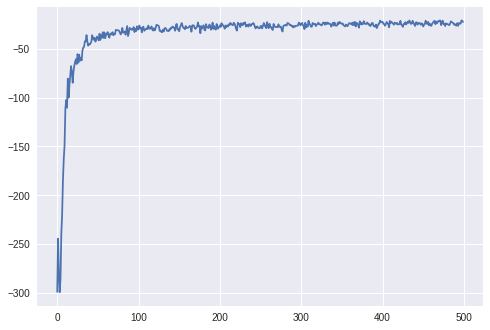


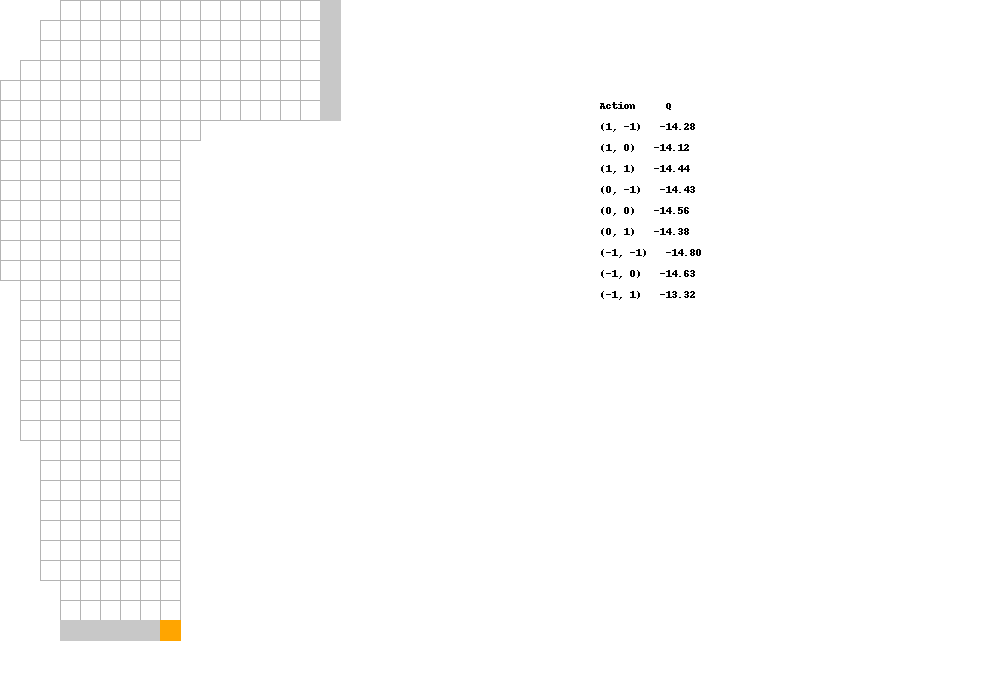
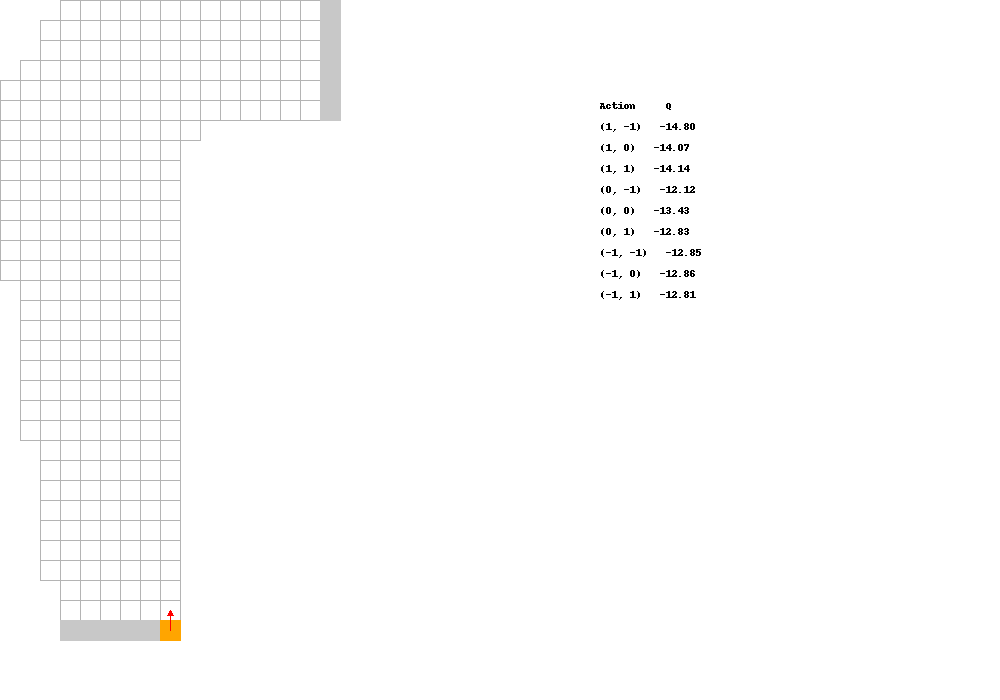
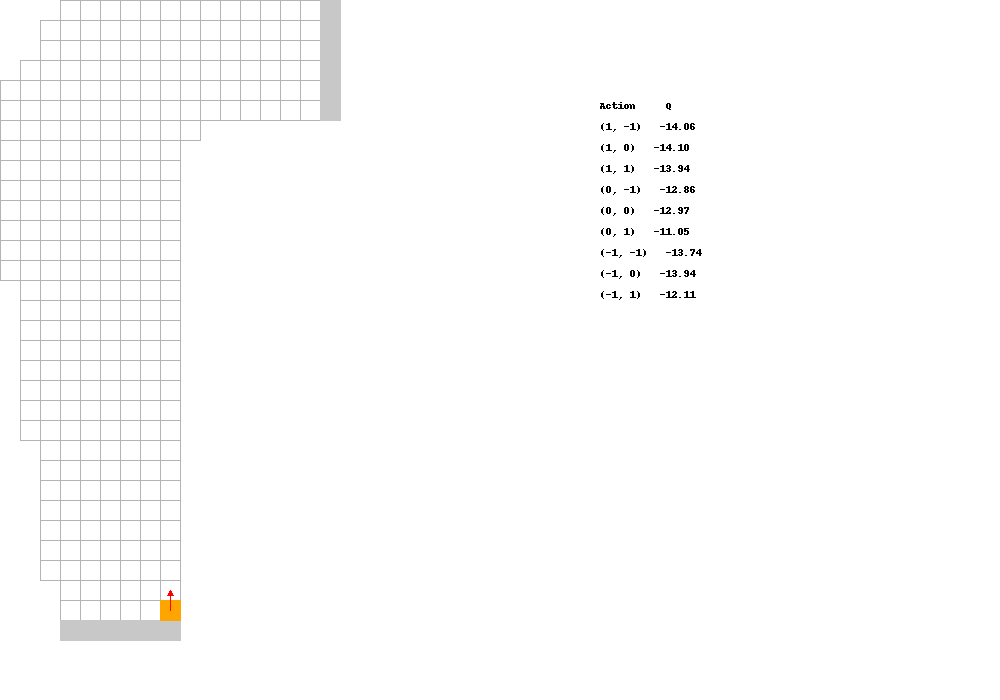
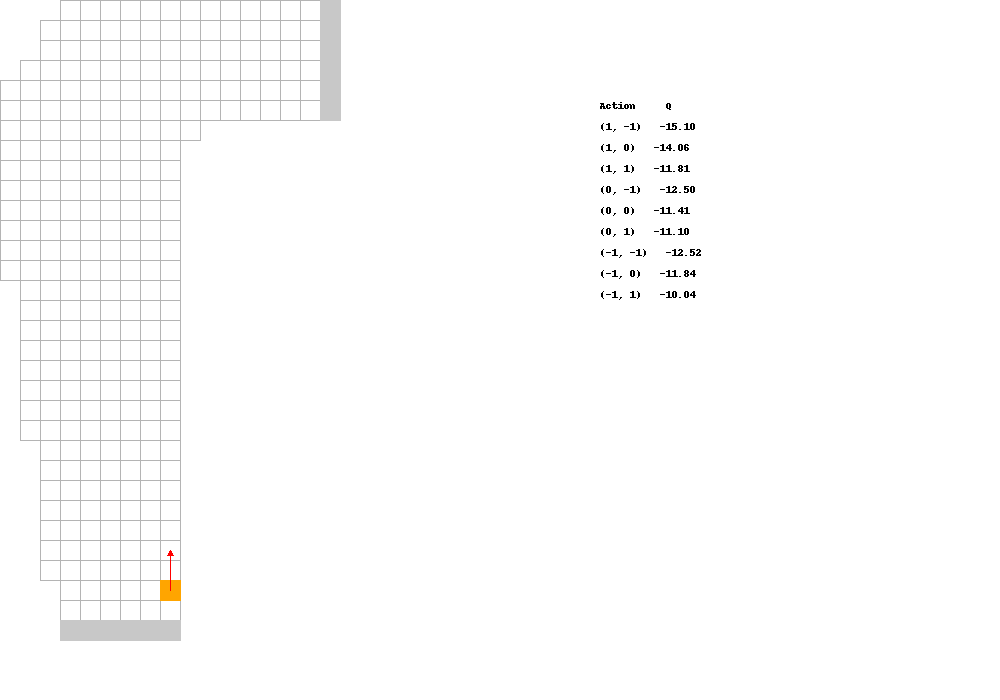
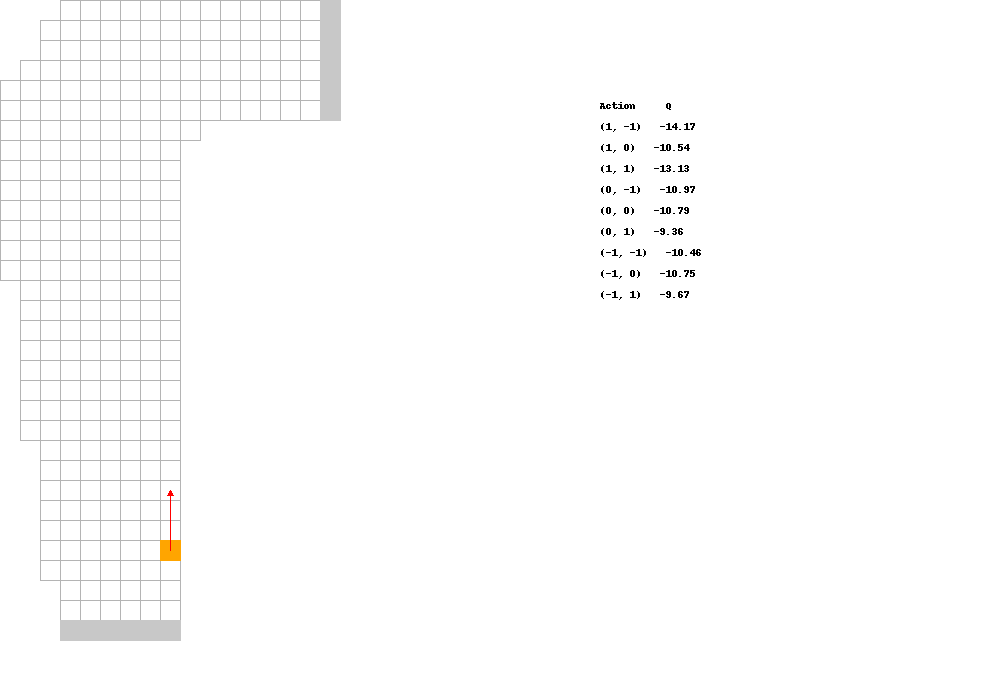
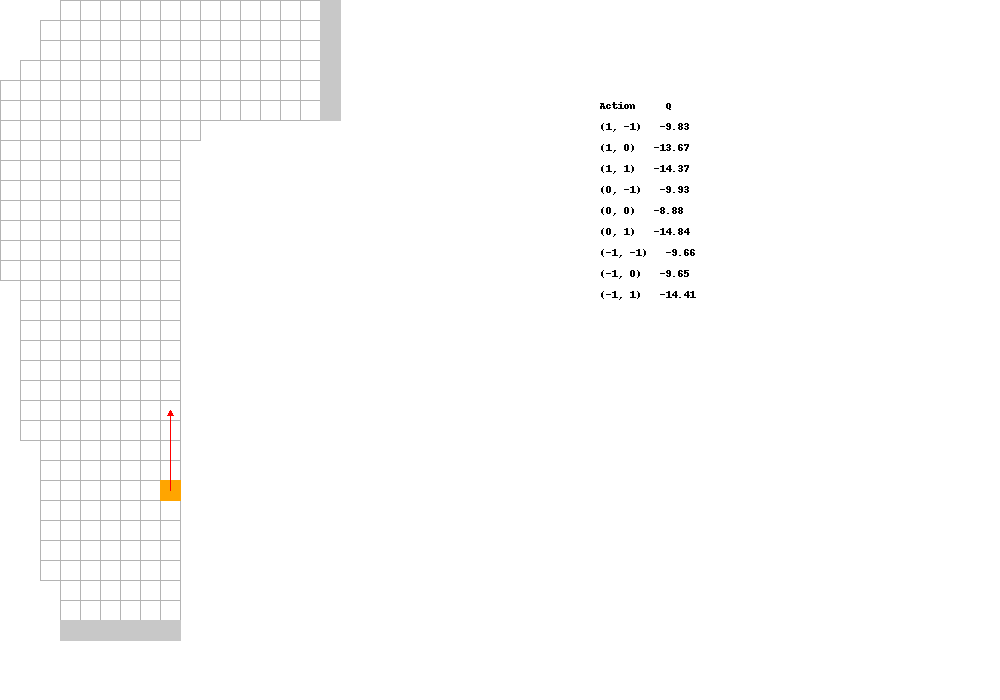
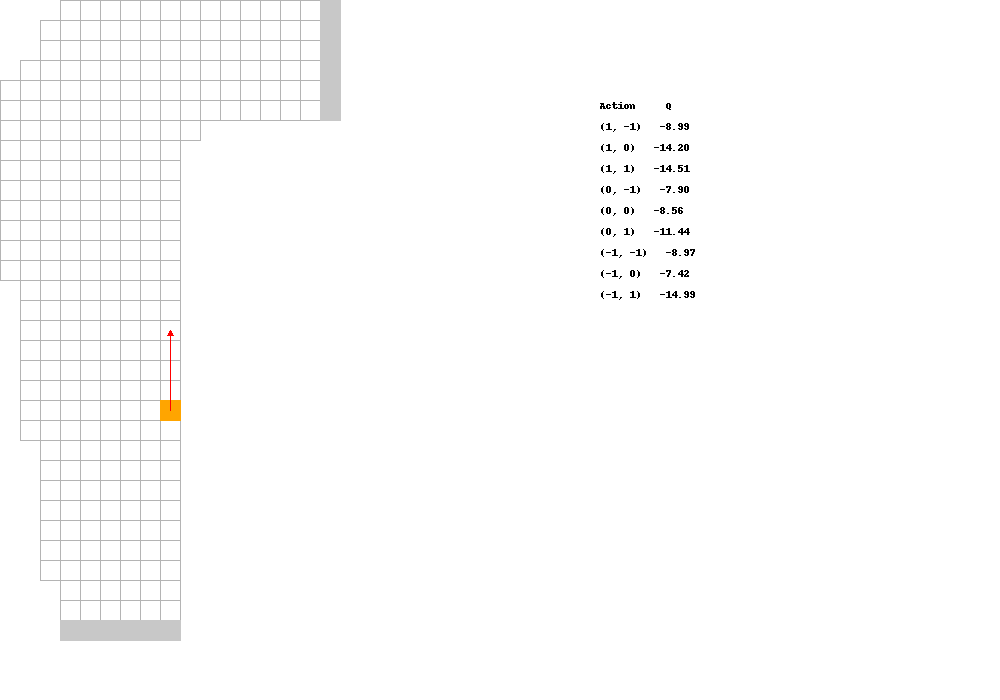
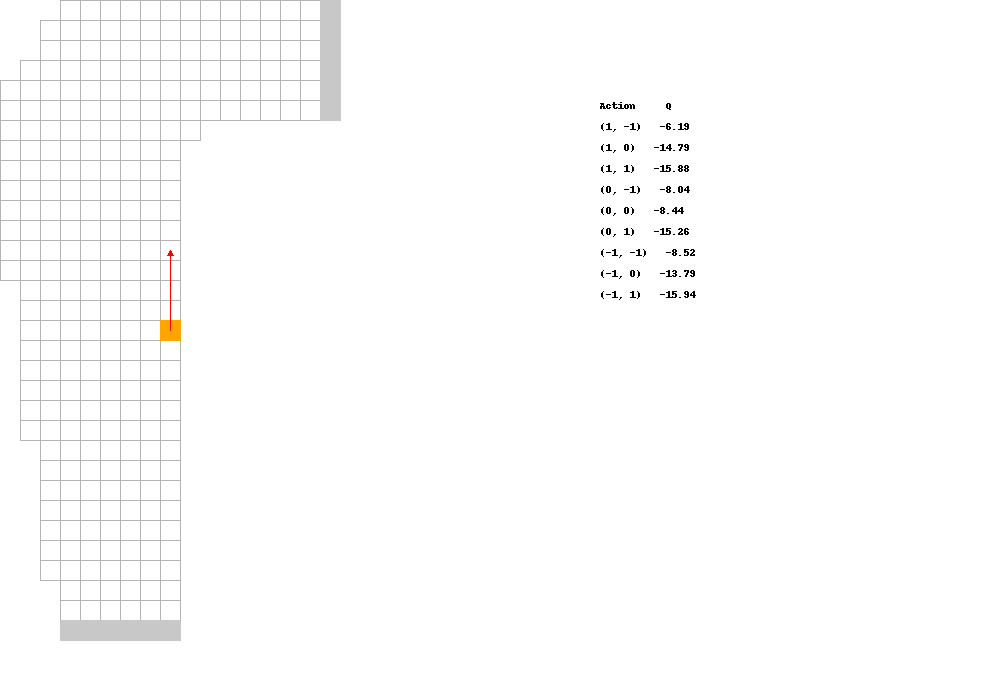
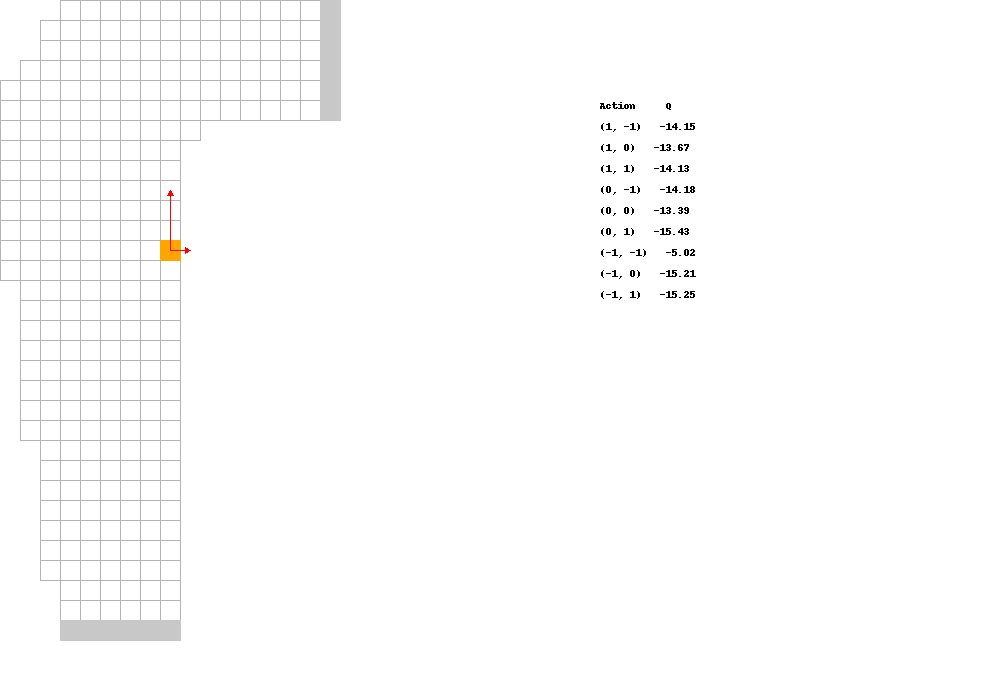
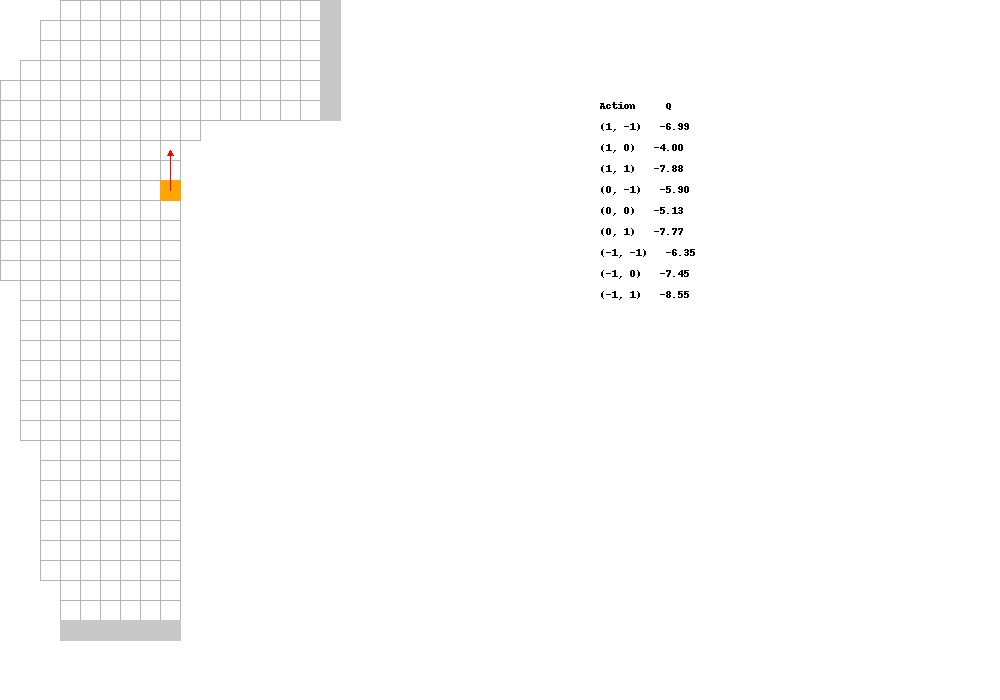
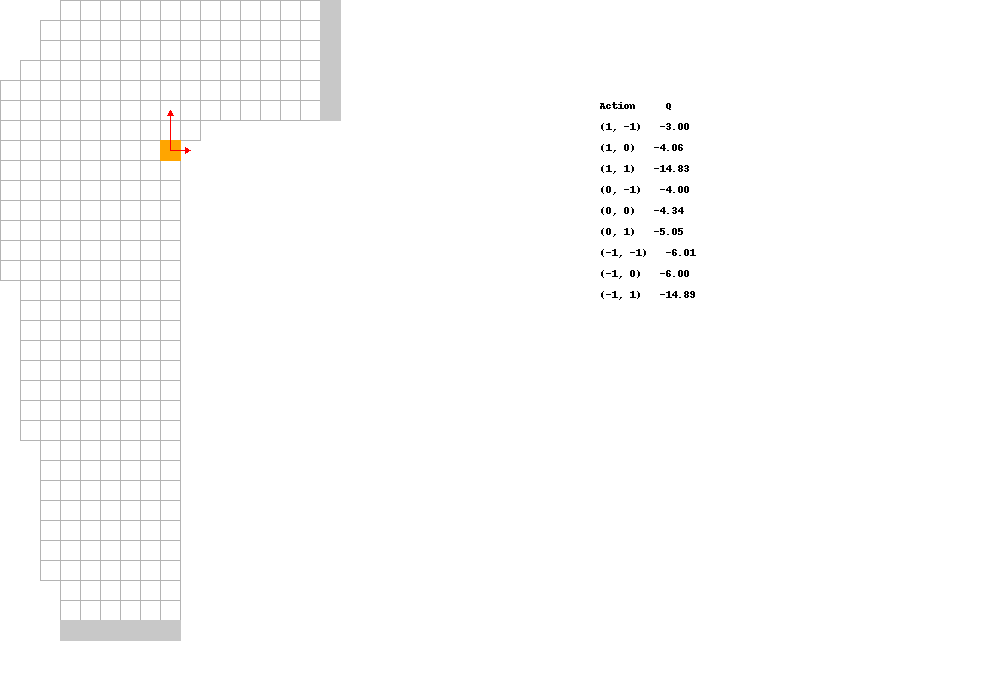
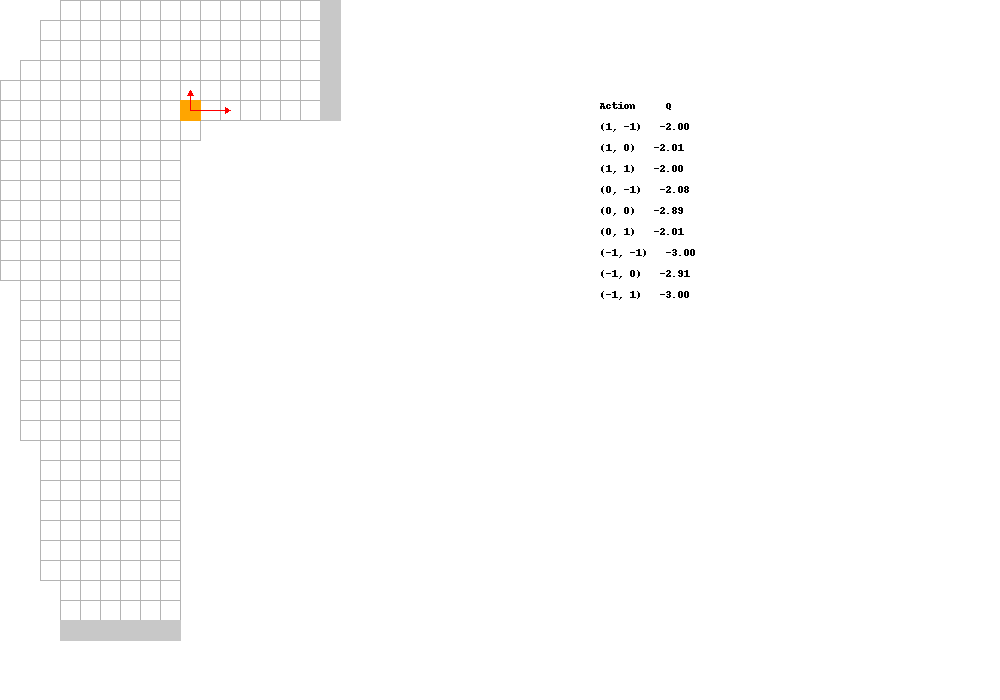
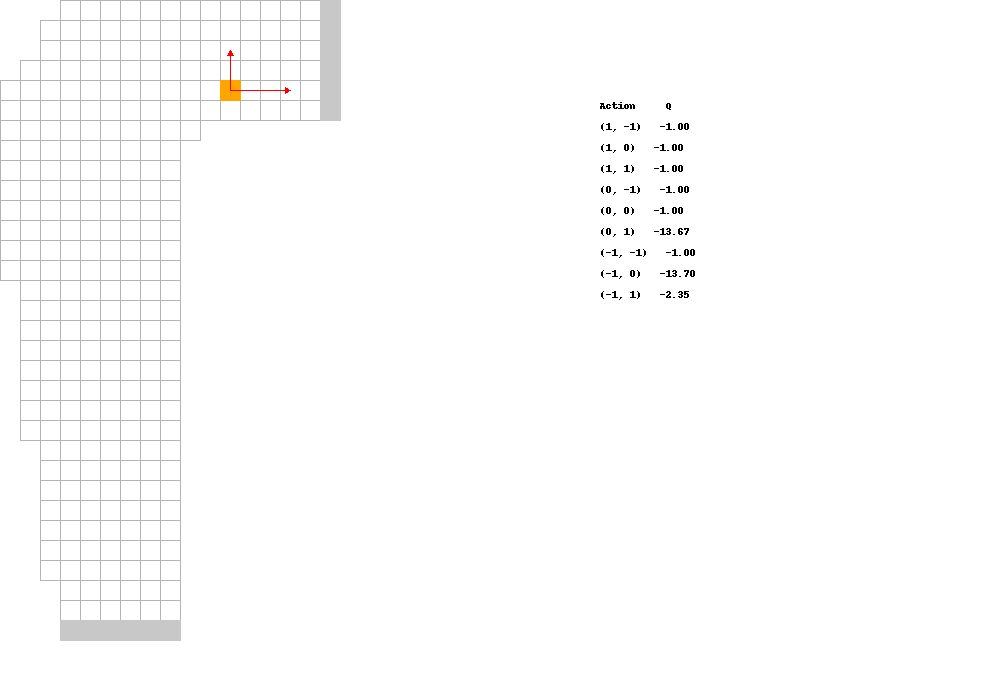
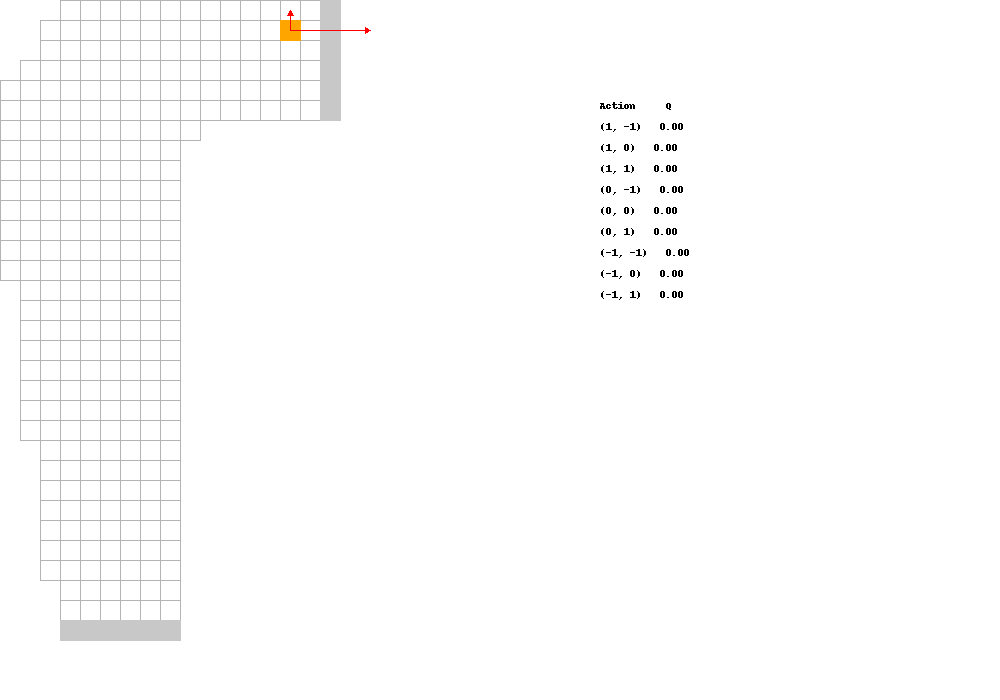

In [0]:
import numpy as np
from IPython.display import display, HTML, Javascript
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import time

TRACK1 = {'start': [[3, 31], [9, 32]], 'finish': [[16, 0], [17, 6]], 'track': [
    [3, 17], [2, 17], [2, 17], [1, 17], [0, 17], [0, 17],
    [0, 10], [0, 9], [0, 9], [0, 9], [0, 9], [0, 9], [0, 9],
    [0, 9], [1, 9], [1, 9], [1, 9], [1, 9], [1, 9], [1, 9],
    [1, 9], [1, 9], [2, 9], [2, 9], [2, 9], [2, 9], [2, 9],
    [2, 9], [2, 9], [3, 9], [3, 9], [3, 9]]}

TRACK2 = {'start': [[3, 31], [8, 31]], 'finish': [[15, 0], [16, 5]], 'track': [
    [16, 33], [13, 33], [12, 33], [11, 33], [11, 33],
    [11, 33], [11, 33], [12, 33], [13, 33], [14, 31],
    [14, 28], [14, 27], [14, 25], [14, 24], [13, 24],
    [12, 24], [11, 24], [10, 24], [9, 24], [8, 24],
    [7, 24], [6, 24], [5, 24], [4, 24], [3, 24], [2, 24],
    [1, 24], [0, 24], [0, 24], [0, 24]
]}

# 9 actions
ACTION_SPACE = [[1,-1], [1,0], [1,1], [0,-1], [0,0], [0,1], [-1,-1], [-1,0], [-1,1]]

# block size for display
BS = 20

# display frames
def display_frames(frames):
    
    import base64, uuid
    from io import BytesIO
    
    obj_id = "ani_" + str(uuid.uuid4()).replace('-', '')
    img_id = "img_" + str(uuid.uuid4()).replace('-', '')
    slider_id = "sli_" + str(uuid.uuid4()).replace('-', '')
    loop_id = "loop_" + str(uuid.uuid4()).replace('-', '')
    javascript = "<link rel=\"stylesheet\" href=\"https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/css/font-awesome.min.css\"><script language=\"javascript\">"
    javascript += "function Animation(t,i,e,r,n){this.img_id=i,this.slider_id=e,this.loop_select_id=n,this.interval=r,this.current_frame=0,this.direction=0,this.timer=null,this.frames=new Array(t.length);"
    javascript += "for(var s=0;s<t.length;s++)this.frames[s]=new Image,this.frames[s].src=t[s];document.getElementById(this.slider_id).max=this.frames.length-1,this.set_frame(this.current_frame)}Animation."
    javascript += "prototype.get_loop_state=function(){for(var t=document[this.loop_select_id].state,i=0;i<t.length;i++){var e=t[i];if(e.checked)return e.value}},Animation.prototype.set_frame=function(t)"
    javascript += "{this.current_frame=t,document.getElementById(this.img_id).src=this.frames[this.current_frame].src,document.getElementById(this.slider_id).value=this.current_frame},Animation.prototype."
    javascript += "next_frame=function(){this.set_frame(Math.min(this.frames.length-1,this.current_frame+1))},Animation.prototype.previous_frame=function(){this.set_frame(Math.max(0,this.current_frame-1))},"
    javascript += "Animation.prototype.first_frame=function(){this.set_frame(0)},Animation.prototype.last_frame=function(){this.set_frame(this.frames.length-1)},Animation.prototype.slower=function(){this.interval/=.7,0"
    javascript += "<this.direction?this.play_animation():this.direction<0&&this.reverse_animation()},Animation.prototype.faster=function(){this.interval*=.7,0<this.direction?this.play_animation():this.direction<0&&this."
    javascript += "reverse_animation()},Animation.prototype.anim_step_forward=function(){if(this.current_frame+=1,this.current_frame<this.frames.length)this.set_frame(this.current_frame);else{var t=this.get_loop_state();"
    javascript += "\"loop\"==t?this.first_frame():\"reflect\"==t?(this.last_frame(),this.reverse_animation()):(this.pause_animation(),this.last_frame())}},Animation.prototype.anim_step_reverse=function(){if(this.current_"
    javascript += "frame-=1,0<=this.current_frame)this.set_frame(this.current_frame);else{var t=this.get_loop_state();\"loop\"==t?this.last_frame():\"reflect\"==t?(this.first_frame(),this.play_animation()):(this.pause_animation(),this.first_frame())}},Animation.prototype.pause_animation=function(){this.direction=0,this.timer&&(clearInterval(this.timer),this.timer=null)},Animation.prototype.play_animation=function(){this.pause_animation(),this.direction=1;var t=this;this.timer||(this.timer=setInterval(function(){t.anim_step_forward()},this.interval))},Animation.prototype.reverse_animation=function(){this.pause_animation(),this.direction=-1;var t=this;this.timer||(this.timer=setInterval(function(){t.anim_step_reverse()},this.interval))};</script>"
    
    html = "<div class=\"animation\" align=\"center\"><img id=\"" + img_id + "\"><br><input id=\"" + slider_id + "\" type=\"range\" style=\"width:350px\" name=\"points\" min=\"0\" max=\"1\" step=\"1\" value=\"0\" onchange=\"" + obj_id + ".set_frame(parseInt(this.value));\"></input><br><button onclick=\"" + obj_id + ".slower()\"><i class=\"fa fa-minus\"></i></button><button onclick=\"" + obj_id + ".first_frame()\"><i class=\"fa fa-fast-backward\"></i></button><button onclick=\"" + obj_id + ".previous_frame()\"><i class=\"fa fa-step-backward\"></i></button><button onclick=\"" + obj_id + ".reverse_animation()\"><i class=\"fa fa-play fa-flip-horizontal\"></i></button><button onclick=\"" + obj_id + ".pause_animation()\"><i class=\"fa fa-pause\"></i></button><button onclick=\"" + obj_id + ".play_animation()\"><i class=\"fa fa-play\"></i></button><button onclick=\"" + obj_id + ".next_frame()\"><i class=\"fa fa-step-forward\"></i></button><button onclick=\"" + obj_id + ".last_frame()\"><i class=\"fa fa-fast-forward\"></i></button><button onclick=\"" + obj_id + ".faster()\"><i class=\"fa fa-plus\"></i></button><form action=\"#n\" name=\"" + loop_id + "\" class=\"anim_control\"><input type=\"radio\" name=\"state\"  value=\"once\" > Once</input><input type=\"radio\" name=\"state\" value=\"loop\" checked> Loop</input><input type=\"radio\" name=\"state\" value=\"reflect\" > Reflect</input></form></div>"
    html += "<script language=\"javascript\">(function(){var img_id = \"%s\";var slider_id=\"%s\";var loop_select_id=\"%s\";var frames = new Array(0);" % (img_id, slider_id, loop_id)

    for i, frame in enumerate(frames):
        buf = BytesIO()
        frame.save(buf, format="PNG")
        imgstr = base64.b64encode(buf.getvalue()).decode('ascii')
        html += "frames[%d] = \"data:image/png;base64,%s\";" % (i,imgstr)
        
    html += "setTimeout(function() {%s = new Animation(frames, img_id, slider_id, 200.0, loop_select_id);}, 0);})()</script>" % obj_id

    display(HTML(javascript + html))

class Racetrack:
    
    def __init__(self, seed=None):
        if seed != None:
            np.random.seed(seed)
        
        self.generate()
        self.reset()
    
    #
    # track is presented by a w * h grid
    #    available posistion uses 1
    #    out-of-border marked as 0
    #    start: 2, finish: 3
    #
    def generate(self, track_data=TRACK1):
        
        self.start = np.array(track_data['start'])
        self.finish = np.array(track_data['finish'])
        t = track_data['track']
        
        self.width = np.max(t)
        self.height = len(t)
        
        # Mark track
        self.track = np.zeros((self.height, self.width))
        for i, [x1, x2] in enumerate(t):
            self.track[i, x1:x2] = 1
        
        # Mark start and finish
        self.track[self.start[0,1]:self.start[1,1], self.start[0,0]:self.start[1,0]] = 2
        self.track[self.finish[0,1]:self.finish[1,1], self.finish[0,0]:self.finish[1,0]] = 3
        
    def draw(self):
        
        img = Image.new('RGB', (1000, 700), (255,255,255))
        d = ImageDraw.Draw(img)
        
        # draw grid
        for x in range(self.width):
            for y in range(self.height):
                if self.track[y, x] == 1:
                    d.rectangle([x*BS, y*BS, (x+1)*BS, (y+1)*BS], outline=(180,180,180))
                elif self.track[y, x] == 2 or self.track[y, x] == 3:
                    d.rectangle([x*BS, y*BS, (x+1)*BS, (y+1)*BS], fill=(200,200,200))
        
        # draw agent
        d.rectangle([self.p[0]*BS, self.p[1]*BS, (self.p[0]+1)*BS, (self.p[1]+1)*BS], fill='orange')
        
        # draw velocity
        half = BS//2
        if self.v[0] != 0:
            end_x = (self.p[0]+self.v[0])*BS+half
            end_y = self.p[1]*BS+half
            d.line([self.p[0]*BS+half, self.p[1]*BS+half, end_x, end_y], fill='red', width=1)
            d.polygon([end_x, end_y, end_x-5, end_y+3, end_x-5, end_y-3, end_x, end_y], fill='red')
        if self.v[1] != 0:
            end_x = self.p[0]*BS+half
            end_y = (self.p[1]-self.v[1])*BS+half
            d.line([self.p[0]*BS+half, self.p[1]*BS+half, end_x, end_y], fill='red', width=1)
            d.polygon([end_x, end_y, end_x-3, end_y+5, end_x+3, end_y+5, end_x, end_y], fill='red')
        
        # print Q
        text = "Action     Q\n"
        for i, a in enumerate(ACTION_SPACE):
            text += "(%d, %d)   %.2f\n" % (a[0], a[1], Q[self.p[0], self.p[1], self.v[0], self.v[1], i])
        d.multiline_text((600, 100), text, fill='black', spacing=10)

        return img

    def reset(self):
        # Pick a position in start line randomly
        self.p = (np.random.randint(self.start[0,0], self.start[1,0]),
                         np.random.randint(self.start[0,1], self.start[1,1]))
        
        # v_x, v_y
        self.v = np.array([0,0])
        
    def step(self, a, noise=True):
        
        action = ACTION_SPACE[a]
        
        # finish flag
        done = False
        r = -1
        
        # calculate intersection
        out, finish = False, False
        
        if self.v[0] > self.v[1]:
            ry = self.v[1] / self.v[0]
            rx = 1
            v = self.v[0]
        elif self.v[0] < self.v[1]:
            ry = 1
            rx = self.v[0] / self.v[1]
            v = self.v[1]
        elif np.sum(self.v) == 0:
            v = 0
            x, y = self.p
        else:
            v = self.v[0]
            ry = rx = 1
        
        # go through all pixel to check
        new_x, new_y = self.p

        for delta in np.arange(0.5, v+0.5, 0.5):
            new_y = new_y - 0.5*ry
            new_x = new_x + 0.5*rx
            
            y = int(new_y)
            x = int(new_x)
            
            # out of track
            if y < 0 or self.track[y, x] == 0:
                out = True
                break
            
            # finish
            if self.track[y, x] == 3:
                finish = True
                break

        # out of track, return to start, v to 0
        if out:
            self.reset()

        # finish
        elif finish:
            r = 0
            done = True

        # update p and v
        else:
            self.p = (x, y)
            
            # no change to velocity with P=0.1
            if not noise or np.random.uniform() > 0.1:
                new_v = np.add(self.v, action)
                
                # nonnegative and no more than 5
                new_v = np.clip(new_v, 0, 5)
                
                # no both 0
                if np.sum(new_v) != 0:
                    self.v = new_v
            
        return (self.p, self.v), r, done

    def episode(self, policy, verbose=False, noise=True):

        frames = []
        
        reward = 0
        done = False
        
        s_list = []
        a_list = []
        r_list = []
        
        s = (self.p, self.v)
        
        while reward > -200 and not done:
            if verbose:
                frames.append(rt.draw())
            
            # generate action
            a, p = policy(s)
            
            # append to list
            s_list.append(s)
            a_list.append((a, p))
            
            # go one step
            s, r, done = self.step(a, noise)
            
            # append to list
            r_list.append(r)
            
            reward += r
    
        return s_list, a_list, r_list, frames


# initialize env
rt = Racetrack()


# Off-policy MC control, for estimating pi_*
Q = np.zeros((rt.width, rt.height, 6, 6, 9))
C = np.zeros((rt.width, rt.height, 6, 6, 9))
pi = np.zeros((rt.width, rt.height, 6, 6))

# number of epoches
epoches = 50000
checkpoint = 2000

# random policy
def policy_random(state):
    return np.random.randint(0, len(ACTION_SPACE)), 1/len(ACTION_SPACE)

# epsilon-greedy policy
epsilon = 0.2
ep_avg = epsilon/len(ACTION_SPACE)
def policy_e_greedy(state):
    (x, y), (vx, vy) = state
    greedy_action = np.argmax(Q[x, y, vx, vy])
    probs = [ep_avg] * 8
    probs.insert(greedy_action, 1-epsilon+ep_avg)
    action = np.random.choice(len(ACTION_SPACE), p=probs)
    return action, 1/probs[action]


# target greedy policy
def policy_greedy(state):
    (x, y), (vx, vy) = state
    #q = Q[x, y, vx, vy]
    #greedy_action = np.random.choice(np.flatnonzero(q == max(q)))
    greedy_action = np.argmax(Q[x, y, vx, vy])
    return greedy_action, 1



def valid(epoch, elapsed):
        rt.reset()
        _, _, rewards, frames = rt.episode(policy_greedy, verbose=False, noise=False)
        if rewards[-1] == 0:
            print("%d epoches run in %.2f secs, validate result: finish in %d" % (epoch+1, elapsed, len(rewards)))
            #display_frames(frames)
        else:
            print("%d epoches run in %.2f secs, validate result: cannot finish" % (epoch+1, elapsed))

        #display_frames(frames)

        

# Monte Carlo
def off_policy_mc_control():

    # reward discount
    gamma = 0.9

    # timer
    timer = time.time()

    end_t = []

    # loop update Q
    for epoch in range(epoches):

        # reset env
        rt.reset()

        # generate an episode using b policy
        s_list, a_list, r_list, _ = rt.episode(policy_e_greedy)

        G = 0
        W = 1

        # T-1, T-2, ... 0
        for t in range(len(s_list)-2, -1, -1):

            # get state
            (x, y), (vx, vy) = s_list[t]
            a, pb = a_list[t]

            G = gamma * G + r_list[t]
            C[x, y, vx, vy, a] += W
            q = Q[x, y, vx, vy, a]
            Q[x, y, vx, vy, a] = q + W*(G-q)/C[x, y, vx, vy, a]

            #print(s_list[t], a, q, Q[x, y, vx, vy, a])
            a_pi, _ = policy_greedy(s_list[t])

            if a_pi != a:
                #print(a_pi, a, t)
                end_t.append(t)
                break
            else:
                W *= 1/pb

        if (epoch+1) % checkpoint == 0:
            valid(epoch, time.time()-timer)

            # tic
            timer = time.time()

    # shows how slow this method learns,
    # only few steps at the tail of episodes contributes to learning.
    list_t = np.array(end_t)
    list_t = np.mean(list_t.reshape(-1, 100), axis=1)
    plt.plot(list_t)
    plt.show()


# TD(0)
V = np.zeros((rt.width, rt.height, 6, 6))

def td():
    
    # alpha
    alpha = 0.9
    gamma = 1
    
    # timer
    timer = time.time()
    
    # rewards
    r_list = []
    
    for epoch in range(epoches):
        
        # reset env
        rt.reset()

        # verbose
        verbose = False
        frames = []
        
        reward = 0
        done = False
        
        s = (rt.p, rt.v)
        # generate action
        a, _ = policy_e_greedy(s)
        
        while reward > -500 and not done:
            if verbose:
                frames.append(rt.draw())
            
            # go one step
            a, _ = policy_e_greedy(s)
            s1, r, done = rt.step(a)
            
            # Choose A' from S' using policy derived from Q
            a1, _ = policy_greedy(s1)

            (x, y), (vx, vy) = s
            (x1, y1), (vx1, vy1) = s1
            q = Q[x, y, vx, vy, a]
            Q[x, y, vx, vy, a] = q + alpha * (r + gamma*Q[x1,y1,vx1,vy1,a1] - q)
            
            s = s1
            
            reward += r
        
        r_list.append(reward)

        # validation
        if (epoch+1) % checkpoint == 0:
            valid(epoch, time.time()-timer)

            # tic
            timer = time.time()
            
    r_list = np.array(r_list)
    r_list = np.mean(r_list.reshape(-1, 100), axis=1)
    plt.plot(r_list)
    plt.show()



#off_policy_mc_control()
td()
#print(len(Q[Q!=0]))
rt.reset()
_, _, _, frames = rt.episode(policy_greedy, verbose=True, noise=False)
display_frames(frames)

<font color='red'>A potential problem is that this method learns only from the tails of episodes, when all of remaining actions in the episode are greedy. If nongreedy actions are common, then learning will be slow, particularly for states appearning in the early portions of long episodes. Potentially, this could **greatly slow** learning.</font>

## 5.8 Discounting-aware Importance Sampling

TO-DO

## 5.9 Per-reward Importance Sampling

TO-DO

# Chapter 6 Temporal-Difference Learning



## 6.1 TD Prediction

MOnte Carlo methods wait until the return following the visit is known, then use that return as a target for $V(S_t)$. A simple every-visit Monte Carlo method suitable for nonstationary environments is:

$$V(S_t)\leftarrow V(S_t) + \alpha\Big[G_t-V(S_t)\Big] \tag{6.1}$$

where $G_t$ is the actual return following time $t$, and $\alpha$ is a constant step-size parameter.

TD methods need to wait only until the next time step. At time $t+1$ they immediately form a target and make a useful update using the observed reward $R_{t+1}$. The simplest TD method makes the update:

$$ V(S_t)\leftarrow V(S_t)+\alpha\Big[R_{t+1}+\gamma V(S_{t+1})-V(S_t)\Big] \tag{6.2}$$

This TD method is call $TD(0)$, or _one-step TD_, because it is a special case of the $TD(\lambda)$ and _n-step_ TD methods.

**Tabular $TD(0)$ for estimating $v_\pi$**

---

Input: the policy $\pi$ to be evaluated<br/>
Initialize $V(s)$ arbitrarily<br/>
Repeat (for each episode):
>Initialize $S$<br/>
>Repeat (for each step of episode):
>>$A \leftarrow $ action given by $\pi$ for $S$<br/>
>>Take action $A$, observe $R, S'$<br/>
>>$V(S)\leftarrow V(S)+\alpha[R+\gamma V(S')-V(S)]$<br/>
>>$S\leftarrow S'$

>until $S$ is terminal

---

The quantity in brackets in the $TD(0)$ update is a sort of error, measuring the difference between the estimated value of $S_t$ and the better estimate $R_{t+1}+\gamma V(S_{t+1})$. This quantity, called the _TD error_:
$$ \delta_t \doteq R_{t+1}+\gamma V(S_{t+1})-V(S_t) \tag{6.5} $$



## 6.2 Advantages of TD Prediction Methods

TD methods have an advantage over DP methods in that they do not require a model of the environment, of its reward and next-state probablity distributions.

The obvious advantage of TD methods over Monte Carlo methods is that they are naturally implemented in an on-line, fully incremental fashion.

TD methods are much less susceptible to these problems because they learn from each transition regardless of what subsequent actions are taken.

## 6.3 Optimality of $TD(0)$

**Batch updating**

Given an approximate value function, $V$, the increments specified by (6.1) or (6.2) are computed for every time step $t$ at which a nonterminal state is visited, but the value function is changed only once, by the sum of all the increments.

Then all the available experience is processed again with the new value function to produce a new overall increment, and so on, until the value function converges.



## 6.4 Sarsa: On-policy TD Control

$$ Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha\Big[R_{t+1}+\gamma Q(S_{t+1}, A_{t+1})-Q(S_t, A_t)\Big] \tag{6.7}$$

This update is done after every transition from a nonterminal state $S_t$. If $S_{t+1}$ is terminal, then $Q(S_{t+1}, A_{t+1})$ is defined as zero.

SARSA: $(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$

---

Initialize $Q(s, a)$, for all $s \in \mathcal{S}$, $a \in \mathcal{A}(s)$, arbitrarily, and $Q(\text{terminal-state}, \cdot) = 0$<br/>
Repeat (for each episode):
>Initialize $S$<br/>
>Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)<br/>
>Repeat (for each step of episode):
>>Take action $A$, observe $R, S'$<br/>
>>Choose $A'$ from $S'$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)<br/>
>>$Q(S,A)\leftarrow Q(S,A) + \alpha [R+\gamma Q(S', A') - Q(S,A)]$<br/>
>>$S\leftarrow S'$; $A \leftarrow A'$

>until $S$ is terminal

---


## 6.5 Q-learning: Off-policy TD Control

$$ Q(S_t, A_t)\leftarrow Q(S_t, A_t)+\alpha\Big[R_{t+1}+\gamma \max_a Q(S_{t+1}, a)-Q(S_t, A_t)\Big] $$

** Q-learning (off-policy TD control) for estimating $\pi\approx\pi_\star$**

---
Initialize $Q(s, a)$, for all $s \in \mathcal{S}$, $a \in \mathcal{A}(s)$, arbitrarily, and $Q(\text{terminal-state}, \cdot) = 0$<br/>
Repeat (for each episode):
>Initialize $S$<br/>
>Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)<br/>
>Repeat (for each step of episode):
>>Take action $A$, observe $R, S'$<br/>
>>Choose $A'$ from $S'$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)<br/>
>>$Q(S,A)\leftarrow Q(S,A) + \alpha [R+\gamma \max_a Q(S', a) - Q(S,A)]$<br/>
>>$S\leftarrow S'$; $A \leftarrow A'$

>until $S$ is terminal

---

## 6.6 Expected Sarsa

$$ \begin{align} Q(S_t, A_t) &\leftarrow Q(S_t, A_t) + \alpha\Big[R_{t+1}+\gamma \mathbb{E}[Q(S_{t+1}, A_{t+1}) | S_{t+1}]-Q(S_t, A_t)\Big] \\
&\leftarrow Q(S_t, A_t) + \alpha\Big[R_{t+1}+\gamma \sum_a \pi(a|S_{t+1})Q(S_{t+1}, a)-Q(S_t, A_t)\Big] \tag{6.9} \end{align} $$

Expected Sarsa might use a policy different from the target policy$\pi$ to generate behavior, in which case it becomes an off-policy algorithm. For example, suppose $\pi$ is the greedy policy while behavior is more exploratory, then Expected Sarsa is exactly Q-learning.

## 6.7 Maximization Bias and Double Learning

In these algorithms (Sarsa, Q-learning), a maximum over estimated values is used implicitly as an estimate of the maximum value, which can lead to a significant positive bias.

Suppose we divided the plays in two sets and used them to learn two independent estimates, call them $Q_1(a)$ and $Q_2(a)$, each an estimate of the true value $q(a)$, for all $a \in \mathcal{A}$.

We could then use one estimate, say $Q_1$, to determine the maximizing action $A^\star=argmax_aQ_1(a)$, and the other, $Q_2$, to provide the estimate of its value, $Q_2(A^\star)=Q_2(argmax_aQ_1(a))$.

We can also repeat the process with the role of the two estimates reversed to yield a second unbiased estimate $Q_1(argmax_aQ_2(a))$.

This is the idea of **_double learning_**.

$$ \DeclareMathOperator*{\argmax}{argmax} Q_1(S_t, A_t)\leftarrow Q_1(S_t, A_t)+\alpha\Big[R_{t+1}+\gamma Q_2(S_{t+1}, \argmax_aQ_1(S_{t+1}, a))-Q_1(S_t,A_t)\Big] \tag{6.10}$$

The behavior policy can use both action-value estimates. For example, an $\epsilon$-greedy policy for Double Q-learning could be based on the average (or sum) of the two action-value estimates.

There are also double versions of Sarsa and Expected Sarsa.

** Double Q-learning **

---
Initialize $Q_1(s,a)$ and $Q_2(s,a)$, for all $s\in\mathcal{S}$, $a\in\mathcal{A}(s)$, arbitrarily<br/>
Initialize $Q_1(\text{terminal-state}, \cdot)=Q_2(\text{terminal-state}, \cdot)=0$<br/>
Repeat (for each episode):
>Initialize $S$<br/>
>Repeat (for each step of episode):
>>Choose $A$ fro $S$  using policy derived from $Q_1$ and $Q_2$ (e.g., $\epsilon$-greedy in $Q_1+Q_2$)<br/>
>>Take action $A$, observe $R$, $S'$<br/>
>>With $0.5$ probability:
>>>$Q_1(S_t, A_t)\leftarrow Q_1(S_t,A_t)+\alpha\big[R_{t+1}+\gamma Q_2(S_{t+1}, argmax_aQ_1(S_{t+1}, a))-Q_1(S_t,A_t)\big]$

>>else:
>>>$Q_2(S_t, A_t)\leftarrow Q_2(S_t,A_t)+\alpha\big[R_{t+1}+\gamma Q_1(S_{t+1}, argmax_aQ_2(S_{t+1}, a))-Q_2(S_t,A_t)\big]$

>>$S\leftarrow S'$

>until $S$ is terminal

---

## 6.8 Games, Afterstates, and Other Special Cases

TO-DO

# Chapter 7: $n$-step Bootstrapping

$n$-step methods span a spectrum with MC methods at one end and one-step TD methods at the other. The best methods are often intermediate between the two extremes.

## 7.1 $n$-step TD Prediction

The target for an arbitrary $n$-step update is the _n-step return_:

$$ G_{t:t+n}\doteq R_{t+1}+\gamma R_{t+2}+\cdots + \gamma^{n-1}R_{t+n}+\gamma^nV_{t+n-1}(S_{t+n}) \tag{7.1}$$

for all $n$,$t$ such that $n\ge 1$ and $0\le t\lt T-n$.

The natural state-value learning algorithm for using $n$-step returns is thus:

$$ V_{t+n}(S_t)\doteq V_{t+n-1}(S_t)+\alpha\big[G_{t:t+n}-V_{t+n-1}(S_t)\big], \qquad 0\le t \lt T, \tag{7.2} $$


**$n$-step TD for estimating$V\approx v_\pi$**

---

Initialize $V(s)$ arbitrarily, $s\in\mathcal{S}$<br/>
Parameters: step size $\alpha \in (0,1]$, a positive integer $n$<br/>
All store and access operations (for $S_t$ and $R_t$) can take their index mod $n$

Repeat (for each episode):
>Initialize and store $S_0 \ne terminal$<br/>
>$T\leftarrow\infty$<br/>
>For $t=0,1,2,\dots$:
>>If $t\le T$, then:
>>>Take an action according to $\pi(\cdot | S_t)$<br/>
>>>Observe and store the next reward as $R_{t+1}$ and the next state as $S_{t+1}$<br/>
>>>If $S_{t+1}$ is terminal, then $T\leftarrow t+1$

>>$\tau\leftarrow t-n+1$  ($\tau$ is the time whose state's estimate is being updated)<br/>
>>If $\tau \ge 0$:
>>>$G\leftarrow\sum_{i=\tau+1}^{min(\tau+n, T)}\gamma^{i-\tau-1}R_i$<br/>
>>>If $\tau+n\le T$, then: $G\leftarrow G+\gamma^nV(S_{\tau+n})$<br/>
>>>$V(S_\tau)\leftarrow V(S_\tau)+\alpha\big[G-V(S_\tau)\big]$

>Until $\tau=T-1$

---

## 7.2 $n$-step Sarsa

$$Q_{t+n}(S_t,A_t)\doteq Q_{t+n-1}(S_t,A_t)+\alpha\big[G_{t:t+n}-Q_{t+n-1}(S_t,A_t)\big], \qquad 0\le t \lt T \tag{7.5}$$

**$n$-step Sarsa for estimating $Q\approx q_\star$, or $Q\approx q_\pi$ for a given $\pi$**

---

Initialize $Q(s,a)$ arbitrarily, for all $s\in\mathcal{S}$, $a \in\mathcal{A}$<br/>
Initialize $\pi$ to be $\epsilon$-greedy will respect to $Q$, or to a fxied given policy<br/>
Parameters: step size $\alpha \in (0,1]$, small $\epsilon\gt0$, a positive integer $n$<br/>
All store and access operations (for $S_t$, $A_t$ and $R_t$) can take their index mod $n$<br/>

Repeat (for each episode):
>Initialize and store $S_0 \ne terminal$<br/>
>Select and store an action $A_0 \sim \pi(\cdot|S_0)$<br/>
>$T\leftarrow\infty$<br/>
>For $t=0,1,2,\dots$:
>>If $t\lt T$, then:
>>>Take action $A_t$<br/>
>>>Observe and store the next reward as $R_{t+1}$ and the next state as $S_{t+1}$<br/>
>>>If $S_{t+1}$ is terminal, then
>>>>$T\leftarrow t+1$

>>>else:
>>>>Select and store an action $A_{t+1}\sim\pi(\cdot|S_{t+1})$

>>$\tau\leftarrow t-n+1$  ($\tau$ is the time whose state's estimate is being updated)<br/>
>>If $\tau \ge 0$:
>>>$G\leftarrow\sum_{i=\tau+1}^{min(\tau+n, T)}\gamma^{i-\tau-1}R_i$<br/>
>>>If $\tau+n\le T$, then: $G\leftarrow G+\gamma^nV(S_{\tau+n})$<br/>
>>>$Q(S_\tau, A_\tau)\leftarrow Q(S_\tau,A_\tau)+\alpha\big[G-Q(S_\tau,A_\tau)\big]$<br/>
>>>If $\pi$ is being learned, then ensure that $\pi(\cdot|S_\tau)$ is $\epsilon$-greedy wrt $Q$

>Until $\tau=T-1$

---

**Expected Sarsa**

It consists of a linear string of sample actions and states, just as in n-step Sarsa, except that its last element is a branch over all action possibilities weighted, as always, by their probability under $\pi$.

$$G_{t:t+n}\doteq R_{t+1}+\cdots+\gamma^{n-1}R_{t+n}+\gamma^n\sum_a\pi(a|S_{t+n})Q_{t+n-1}(S_{t+n},a)  \tag{7.6}$$

## 7.3 $n$-step Off-policy Learning by Importance Sampling

** off-policy version of n-step TD **

$$ V_{t+n}(S_t)\doteq V_{t+n-1}(S_t)+\alpha\rho_{t:t+n-1}\big[G_{t:t+n}-V_{t+n-1}(S_t)\big], \qquad 0\le t \lt T \tag{7.7} $$

$$ \rho_{t:h}\doteq \prod_{k=t}^{min(h,T-1)}\frac{\pi(A_k|S_k)}{b(A_k|S_k)} \tag{7.8}$$

** off-policy n-step Sarsa with importance sampling ratio **

$$Q_{t+n}(S_t,A_t)\doteq Q_{t+n-1}(S_t,A_t)+\alpha\rho_{t+1:t+n-1}\big[G_{t:t+n}-Q_{t+n-1}(S_t,A_t)\big], \qquad 0\le t \lt T \tag{7.9}$$

**Off-policy $n$-step Sarsa for estimating $Q\approx q_\star$, or $Q\approx q_\pi$ for a given $\pi$**

---
Input: an arbitrary behavior policy $b$ such that $b(a|s)\gt0$, for all $s\in\mathcal{S}$, $a\in\mathcal{A}$<br/>
Initialize $Q(s,a)$ arbitrarily, for all $s\in\mathcal{S}$, $a \in\mathcal{A}$<br/>
Initialize $\pi$ to be $\epsilon$-greedy will respect to $Q$, or to a fxied given policy<br/>
Parameters: step size $\alpha \in (0,1]$, small $\epsilon\gt0$, a positive integer $n$<br/>
All store and access operations (for $S_t$, $A_t$ and $R_t$) can take their index mod $n$<br/>

Repeat (for each episode):
>Initialize and store $S_0 \ne terminal$<br/>
>Select and store an action $A_0 \sim \pi(\cdot|S_0)$<br/>
>$T\leftarrow\infty$<br/>
>For $t=0,1,2,\dots$:
>>If $t\lt T$, then:
>>>Take action $A_t$<br/>
>>>Observe and store the next reward as $R_{t+1}$ and the next state as $S_{t+1}$<br/>
>>>If $S_{t+1}$ is terminal, then
>>>>$T\leftarrow t+1$

>>>else:
>>>>Select and store an action $A_{t+1}\sim\pi(\cdot|S_{t+1})$

>>$\tau\leftarrow t-n+1$  ($\tau$ is the time whose state's estimate is being updated)<br/>
>>If $\tau \ge 0$:
>>>$\rho\leftarrow \prod_{i=\tau+1}^{min(\tau+n-1, T-1)}\frac{\pi(A_\tau|S_\tau)}{b(A_\tau|S_\tau)}$<br/>
>>>$G\leftarrow\sum_{i=\tau+1}^{min(\tau+n, T)}\gamma^{i-\tau-1}R_i$<br/>
>>>If $\tau+n\le T$, then: $G\leftarrow G+\gamma^nV(S_{\tau+n})$<br/>
>>>$Q(S_\tau, A_\tau)\leftarrow Q(S_\tau,A_\tau)+\alpha\rho\big[G-Q(S_\tau,A_\tau)\big]$<br/>
>>>If $\pi$ is being learned, then ensure that $\pi(\cdot|S_\tau)$ is $\epsilon$-greedy wrt $Q$

>Until $\tau=T-1$

---

## 7.4 *Per-reward Off-policy Methods

pass

## 7.5 Off-policy Learning Without Importance Sampling: The $n$-step Tree Backup Algorithm

Each first-level action $a$ contributes with a weight of $\pi(a|S_{t+1})$, except that the action actually taken, $A_{t+1}$, does not contribute at all. Its probability, $\pi(A_{t+1}|S_{t+1})$, is used to weight all the second-level action values. Thus, each non-selected second-level action $a'$ contributes with weight $\pi(A_{t+1}|S_{t+1})\pi(a'|S_{t+2})$. Each third-level action contributes with weight $\pi(A_{t+1}|S_{t+1})\pi(A_{t+2}|S_{t+2})\pi(a''|S_{t+3})$, and so on.

The one-step return (target) of the tree-backup algorithm is the same as that of Expected Sarsa. 

$$ \begin{align} G_{t:t+1}&\doteq R_{t+1}+\gamma\sum_a\pi(a|S_{t+1})Q_t(S_{t+1}, a) \\
&=\delta'_t+Q_{t-1}(S_t,A_t) \end{align} $$

where $\delta'_t$is a modified form of the TD error from Expected Sarsa:

$$ \delta'_t \doteq R_{t+1}+\gamma\sum_a\pi(a|S_{t+1})Q_t(S_{t+1}, a)-Q_{t-1}(S_t,A_t) \tag{7.12} $$

With these, the general $n$-step returns of the tree-backup algorithm can be defined recursively, and then as a sum of TD errors:

$$\begin{align}
G_{t:t+n} &\doteq R_{t+1}+\gamma\sum_{a\ne A_{t+1}}\pi(a|S_{t+1})Q_t(S_{t+1}, a)+\gamma\pi(A_{t+1}|S_{t+1})G_{t+1:t+n} \tag{7.13}\\
&=\delta'_t+Q_{t-1}(S_t,A_t)-\gamma\pi(A_{t+1}|S_{t+1})Q_t(S_{t+1}, A_{t+1})+\gamma\pi(A_{t+1}|S_{t+1})G_{t+1:t+n} \\
&=Q_{t-1}(S_t,A_t)+\sum_{k=t}^{min(t+n-1, T-1)}\delta'_k\prod_{i=t+1}^{k}\gamma\pi(A_i|S_i)
\end{align}$$

<br/><br/>

** $n$-step Tree Backup for estimating $Q\approx q_\star$, or $Q\approx q_\pi$ for a given $\pi$ **

---
Initialize $Q(s,a)$ arbitrarily, for all $s\in\mathcal{S}$, $a \in\mathcal{A}$<br/>
Initialize $\pi$ to be $\epsilon$-greedy will respect to $Q$, or to a fxied given policy<br/>
Parameters: step size $\alpha \in (0,1]$, small $\epsilon\gt0$, a positive integer $n$<br/>
All store and access operations (for $S_t$, $A_t$ and $R_t$) can take their index mod $n$<br/>

Repeat (for each episode):
>Initialize and store $S_0 \ne terminal$<br/>
>Select and store an action $A_0 \sim \pi(\cdot|S_0)$<br/>
>$T\leftarrow\infty$<br/>
>For $t=0,1,2,\dots$:
>>If $t\lt T$, then:
>>>Take action $A_t$<br/>
>>>Observe and store the next reward as $R_{t+1}$ and the next state as $S_{t+1}$<br/>
>>>If $S_{t+1}$ is terminal, then
>>>>$T\leftarrow t+1$
>>>>Store $R-Q_t$ as $\delta_t$

>>>else:
>>>>Store $R+\gamma\sum_a\pi(a|S_{t+1})Q(S_{t+1}, a)-Q_t$ as $\delta_t$<br/>
>>>>Select arbitrarily and store an action as $A_{t+1}$<br/>
>>>>Store $Q(S_{t+1}, A_{t+1})$ as $Q_{t+1}$<br/>
>>>>Store $\pi(A_{t+1}|S_{t+1})$ as $\pi_{t+1}$

>>$\tau\leftarrow t-n+1$  ($\tau$ is the time whose state's estimate is being updated)<br/>
>>If $\tau \ge 0$:
>>>$Z\leftarrow 1$<br/>
>>>$G\leftarrow Q_\tau$<br/>
>>>For $k=\tau,\dots,min(\tau+n-1, T-1)$:
>>>>$G\leftarrow G+Z\delta_k$<br/>
>>>>$Z\leftarrow \gamma Z\pi_{k+1}$

>>>$Q(S_\tau, A_\tau)\leftarrow Q(S_\tau,A_\tau)+\alpha\big[G-Q(S_\tau,A_\tau)\big]$<br/>
>>>If $\pi$ is being learned, then ensure that $\pi(\cdot|S_\tau)$ is $\epsilon$-greedy wrt $Q(S_\tau,\cdot)$

>Until $\tau=T-1$
---

## 7.6 *A Unifying Algorithm: $n$-step $Q(\sigma)$

pass